In [2]:

# import pandas as pd
# import plotly.express as px 
# data1 = []
# picked_layers = [["patch_embed", model.backbone.net.patch_embed],["layer_0" , model.backbone.net.layers[0]],
#    ["layer_1" , model.backbone.net.layers[1]],["layer_2" , model.backbone.net.layers[2]],["final"   , model.backbone.net.final],
# ]

# for model_name,m in picked_layers:
#     for module_name, p in m.named_parameters():
#         key = module_name
#         data1.append([f"{module_name}.{tuple(p.shape)}",np.prod(p.shape),model_name])  


# data2 = []
# picked_layers = [
#    ["patch_embed", model.backbone.net.patch_embed],
#    ["layer_0" , model.backbone.net.layers[0]],
#    ["layer_1" , model.backbone.net.layers[1]],
#    ["layer_2" , model.backbone.net.layers[2]],
#    ["final"   , model.backbone.net.final],
# ]

# for model_name,m in picked_layers:
#     for module_name, p in m.named_parameters():
#         key = module_name
#         data2.append([f"{module_name}.{tuple(p.shape)}",np.prod(p.shape),model_name])  


# import plotly.express as px
# from plotly.subplots import make_subplots
# names_col = ['layer','ParaM', 'block']
# plot_df1 = pd.DataFrame(data=data1,columns=names_col)
# plot_df2 = pd.DataFrame(data=data2,columns=names_col)

# fig = make_subplots(rows=1, cols=1)
# fig1 = px.bar(plot_df1, x='block', y='ParaM',color_discrete_sequence=['red'])
# fig2 = px.bar(plot_df2, x='block', y='ParaM',color_discrete_sequence=['blue'])
# fig.add_trace(fig1['data'][0], row=1, col=1)
# fig.add_trace(fig2['data'][0], row=1, col=1)
# fig.show()

##### plot 3 step finetune/pretrain

In [30]:
ST2MSE = "v5sdcu4j"
ST2ROG = "1qy1q37h"
PT2MSE = "1fokzc5w"
PT2ROG = "zr8bqb4s"

In [31]:
run = api.run(path=f"szztn951357/WeathBench7066/1qy1q37h")

In [32]:
import wandb
import numpy as np
import re
api = wandb.Api()
error_list = ['test_rmse_unit_500hPa_geopotential','test_rmse_unit_850hPa_temperature']
data_pool = {}
for name, _id in zip(['S:T+2:MSE','S:T+2:MLSE','P:T+2:MSE','P:T+2:MLSE'],[ST2MSE,ST2ROG,PT2MSE,PT2ROG]):
    run = api.run(path=f"szztn951357/WeathBench7066/{_id}")
    if name not in data_pool:data_pool[name]={}
    for row in run.scan_history():
        for error in error_list:
            if error in row:
                time_step = row['time_step']
                #real_time = row['real_time']
                if time_step not in data_pool[name]:
                    data_pool[name][time_step]={}
                data_pool[name][time_step][error]=row[error]

In [36]:
from mltool.visualization import *

In [52]:
import os

In [53]:
os.mkdir('figures')

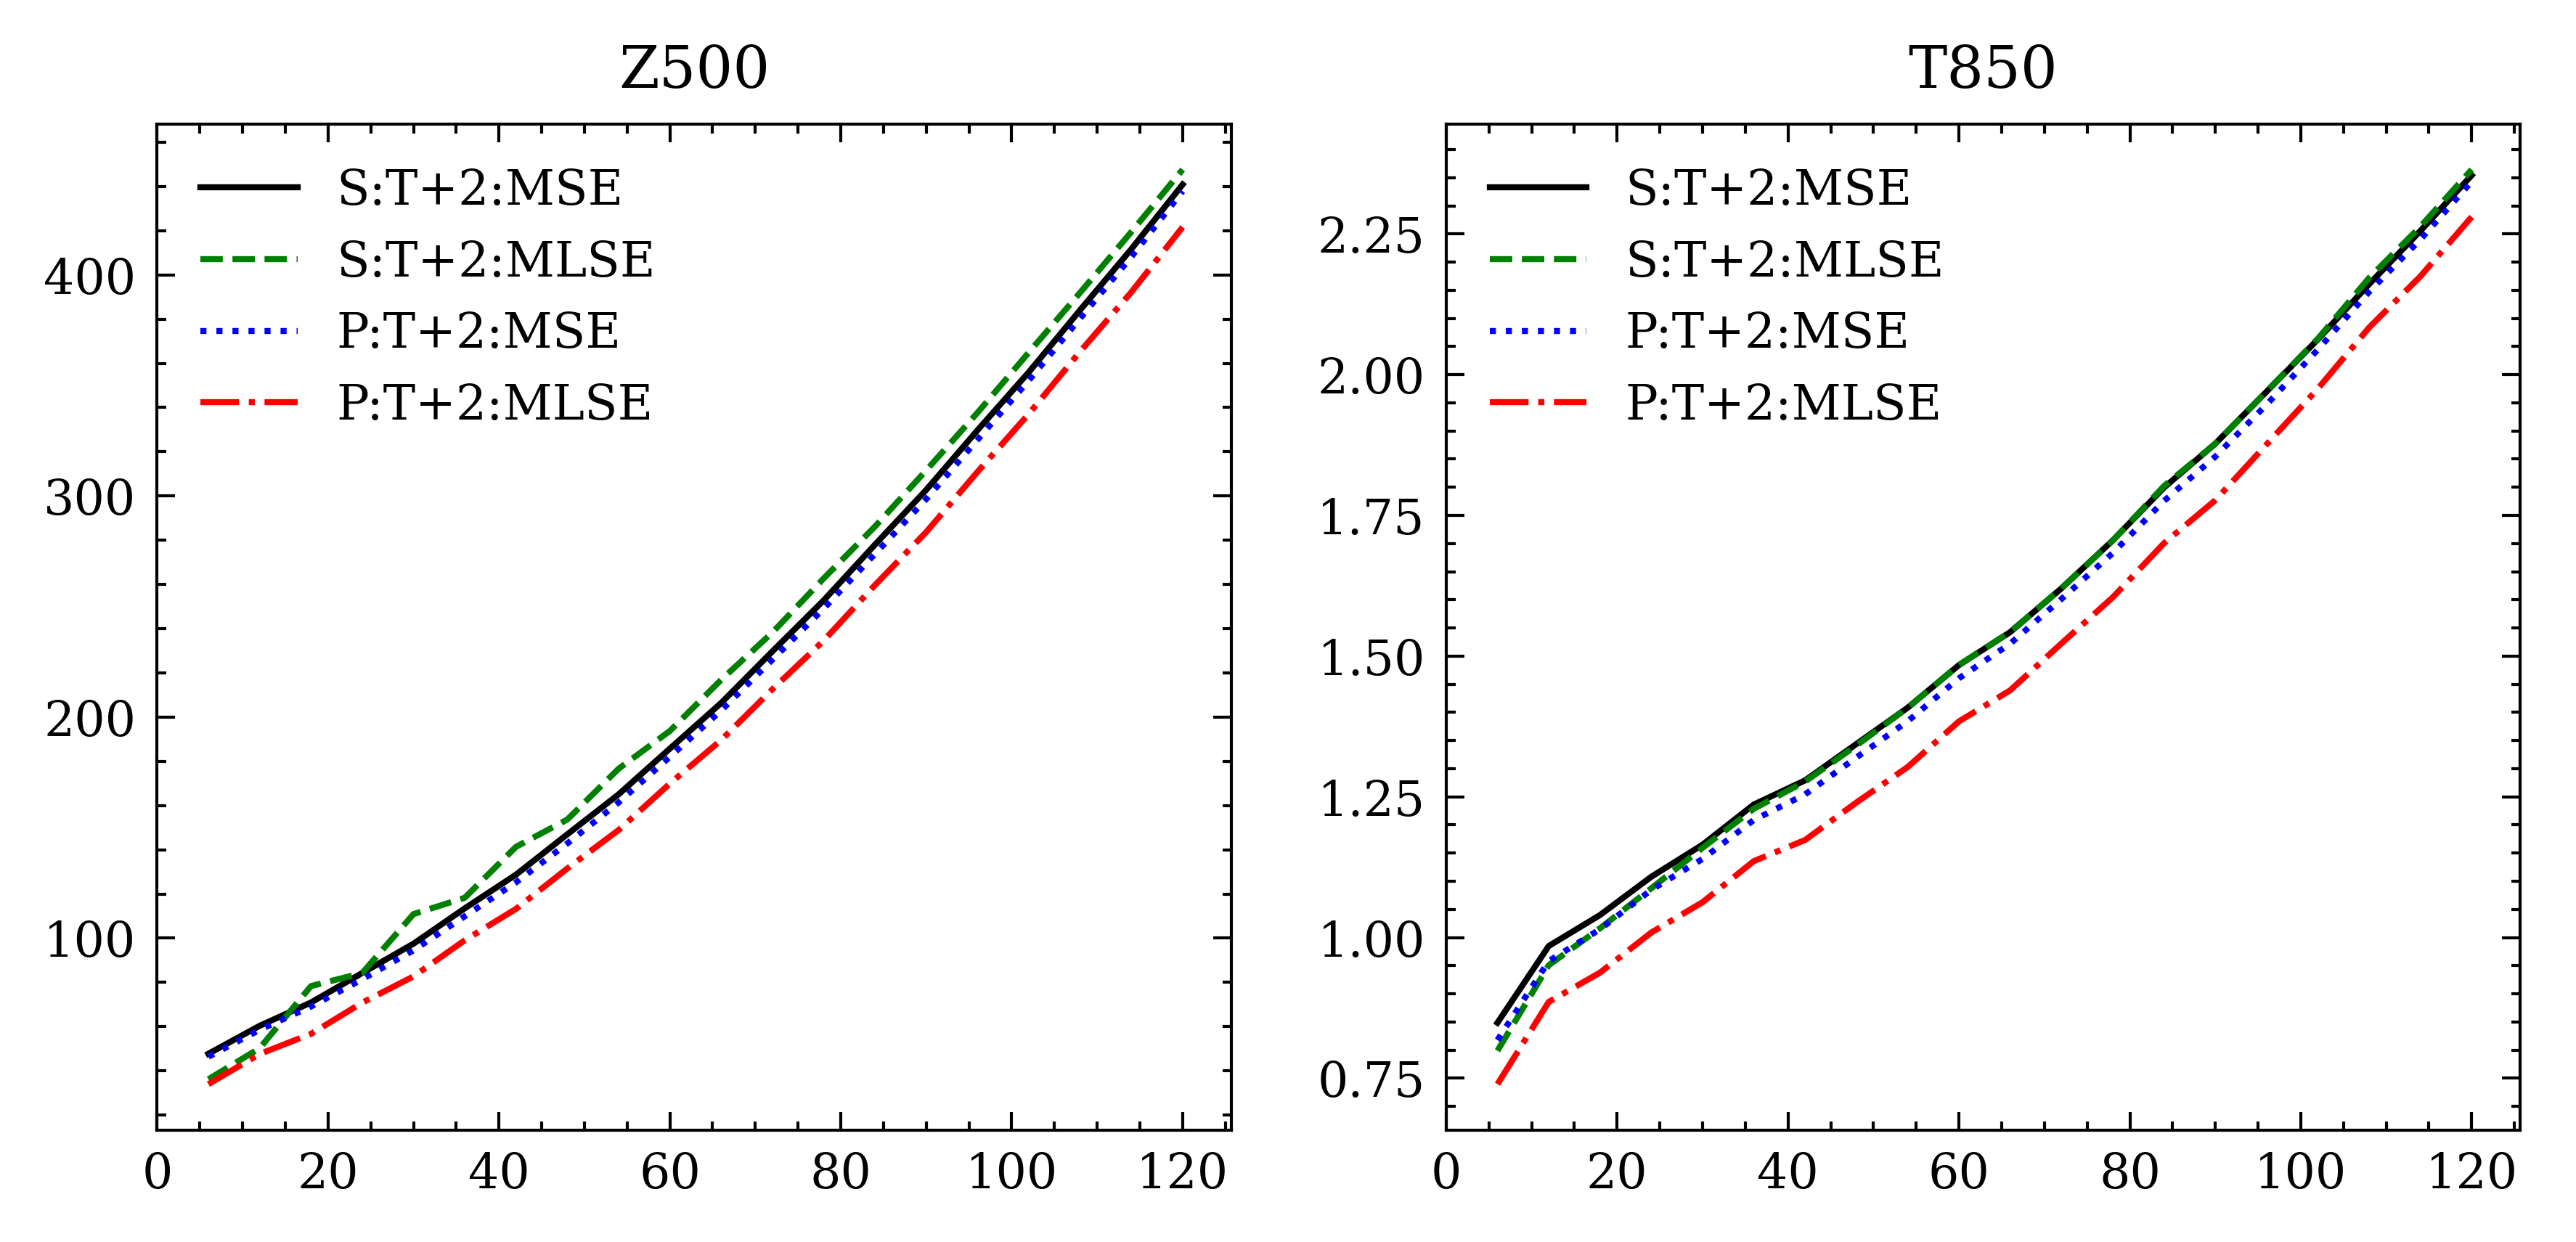

In [54]:
%matplotlib inline
import scienceplots
with plt.style.context(['science', 'no-latex', 'ieee']):         
    fig, axes = plt.subplots(1,2,figsize=(7, 3))
    colorlist=['black','g','b','r','black','purple','magenta','orange']

    ax = axes[0]
    for index,(task_name, task_pool) in enumerate(data_pool.items()):
        xes = [(i+1)*6 for i in range(20)]
        Z500= [task_pool[i]['test_rmse_unit_500hPa_geopotential'] for i in range(20)]
        ax.plot(xes,Z500,label=task_name,color=colorlist[index])
        ax.set_xticks([0,20,40,60,80,100,120])
        ax.set_title("Z500")
        ax.legend()
    ax = axes[1]
    for index,(task_name, task_pool) in enumerate(data_pool.items()):
        xes = [(i+1)*6 for i in range(20)]
        T850= [task_pool[i]['test_rmse_unit_850hPa_temperature'] for i in range(20)]
        ax.plot(xes,T850,label=task_name,color=colorlist[index])
        ax.set_xticks([0,20,40,60,80,100,120])
        ax.set_title("T850")
        ax.legend()
fig.savefig("figures/3-step-finetune-or-pretrain.png",dpi=300)

#### plot different file step

In [ ]:
import numpy as np

In [ ]:
for time_intervel in data_pool.keys():
    for key, val in data_pool[time_intervel].items():
        data_pool[time_intervel][key] = np.array(val)

In [ ]:
from mltool.visualization import *

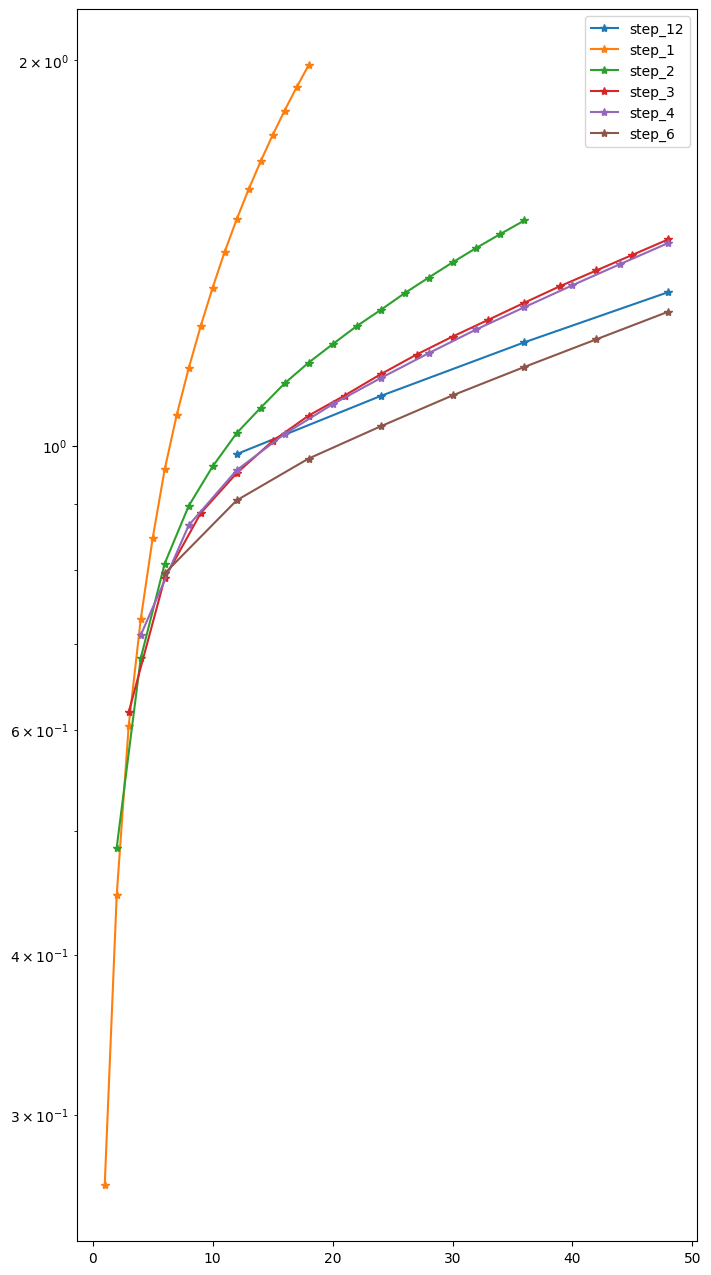

In [ ]:
%matplotlib inline
name = 'test_rmse_unit_850hPa_temperature'
fig = plt.figure(figsize=(8,16))
xmax = 50
xdata=np.arange(xmax)
ydata=np.arange(xmax)
for time_intervel in data_pool.keys():
    xdata= time_intervel*(np.arange(len(data_pool[time_intervel]['real_time']))+1)
    ydata= data_pool[time_intervel][name]
    
    x_id = xdata<xmax
    
    ydata=ydata[x_id]
    xdata=xdata[x_id]
    plt.plot(xdata,ydata,'*-',label=f'step_{time_intervel}')

plt.legend()
plt.legend()
plt.yscale('log')
plt.savefig("img/test_rmse_unit_850hPa_temperature_Weatherbench_in_different_time_step_finetune.png")

In [4]:
from mytool import *

In [5]:
ckpt_path = "checkpoints/WeathBench7066/AFNONet/time_step_2_pretrain-2D706N_every_1_step/11_21_20_49_50-seed_73001/wo_amp/"

In [6]:
#if "figures" in os.listdir(ckpt_path):return
from train.pretrain import create_nodal_loss_snap_metric_table,get_test_dataset,LoggingSystem,parse_default_args,create_logsys
import torch
# if 'rmse_unit_table' in os.listdir(ckpt_path):
#     return
args = get_the_args(ckpt_path)
args.mode = 'fourcast_for_snap_nodal_loss'
args.gpu = args.local_rank = gpu  = local_rank = 0
#args.data_root = "datasets/weatherbench"
##### parse args: dataset_kargs / model_kargs / train_kargs  ###########
args= parse_default_args(args)
args.SAVE_PATH = ckpt_path
########## inital log ###################
args.distributed = False
test_dataset,   test_dataloader = get_test_dataset(args)
#args.SAVE_PATH = './debug'
args.use_wandb = 'off'
args.wandb_id  = None
logsys = create_logsys(args,False)

use dataset in datasets/weatherbench_6hour
load data from datasets/weatherbench_6hour/test.npy
log at checkpoints/WeathBench7066/AFNONet/time_step_2_pretrain-2D706N_every_1_step/11_21_20_49_50-seed_73001/wo_amp/
wandb id: None
wandb is off, the recorder list is  ['tensorboard'], we pass wandb


In [7]:
fourcastresult = ckpt_path

In [8]:
prefix_pool={
    'only_backward':"time_reverse_",
    'only_forward':""
}
prefix = prefix_pool[test_dataset.time_reverse_flag]

if isinstance(fourcastresult,str):
    # then it is the fourcastresult path
    ROOT= fourcastresult
    fourcastresult_list = [os.path.join(ROOT,p) for p in os.listdir(fourcastresult) if 'nodal_snap_on_test_dataset.gpu' in p]
    fourcastresult={}
    for save_path in fourcastresult_list:
        tmp = torch.load(save_path)
        for key,val in tmp.items():
            if key not in fourcastresult:
                fourcastresult[key] = val

property_names = test_dataset.vnames
property_select= fourcastresult['property_select']

L1meassures = torch.stack([p['L1meassure'].cpu() for p in fourcastresult.values() if 'L1meassure' in p]) #(B, fourcast_num, Pick_property_num, W,H)
L2meassures = torch.stack([p['L2meassure'].cpu() for p in fourcastresult.values() if 'L2meassure' in p]) #(B, fourcast_num, Pick_property_num, W,H)
if len(L1meassures.shape)==6 and L1meassures.shape[2]==1:L1meassures=L1meassures[:,:,0]
if len(L2meassures.shape)==6 and L2meassures.shape[2]==1:L2meassures=L2meassures[:,:,0]

print(L1meassures.shape)
print(L2meassures.shape)
select_keys = [k for k in fourcastresult.keys() if isinstance(k,int)]

torch.Size([25, 17, 2, 32, 64])
torch.Size([25, 17, 2, 32, 64])


In [10]:
for meassure, metric_name in zip([L1meassures,L2meassures],['L1','L2']):
        for fourcast_step, tensor_per_property in enumerate(meassure.permute(1,2,0,3,4).flatten(-3,-1)):
            for property_id, tensor in enumerate(tensor_per_property):
                property_name = property_names[property_select[property_id]]
                data = tensor.numpy()
                raise

RuntimeError: No active exception to reraise

In [13]:
from mltool.visualization import smoothhist


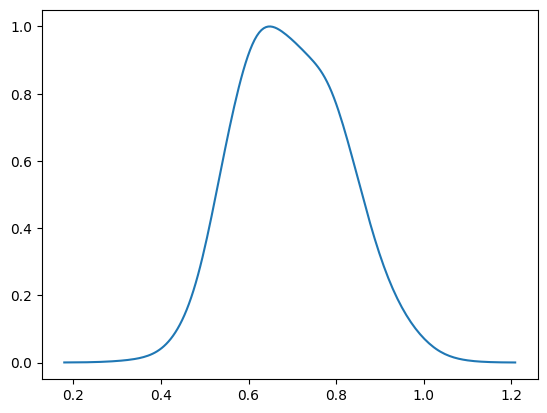

In [14]:
%matplotlib inline
smoothhist(data)